In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import albumentations as A
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

In [2]:
# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
data = pd.read_csv(r'D:\automatic-vote-counting-image\IMAGE DATASET\train.csv')
data.head()

,data,label
0,12_248.jpeg,12
1,39_1627.jpeg,39
2,22_536.jpeg,22
3,33_612.jpeg,33
4,1_1158.jpeg,1


In [4]:
labels = data['label'].values
print(set(labels))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47}


In [5]:
test_data = pd.read_csv(r'D:\automatic-vote-counting-image\IMAGE DATASET\test.csv')
test_data.head()

,data,label
0,4_2445_313.jpeg,-1
1,8_8666_1727.jpeg,-1
2,43_5321_1163.jpeg,-1
3,41_1960_1762.jpeg,-1
4,34_8934_795.jpeg,-1


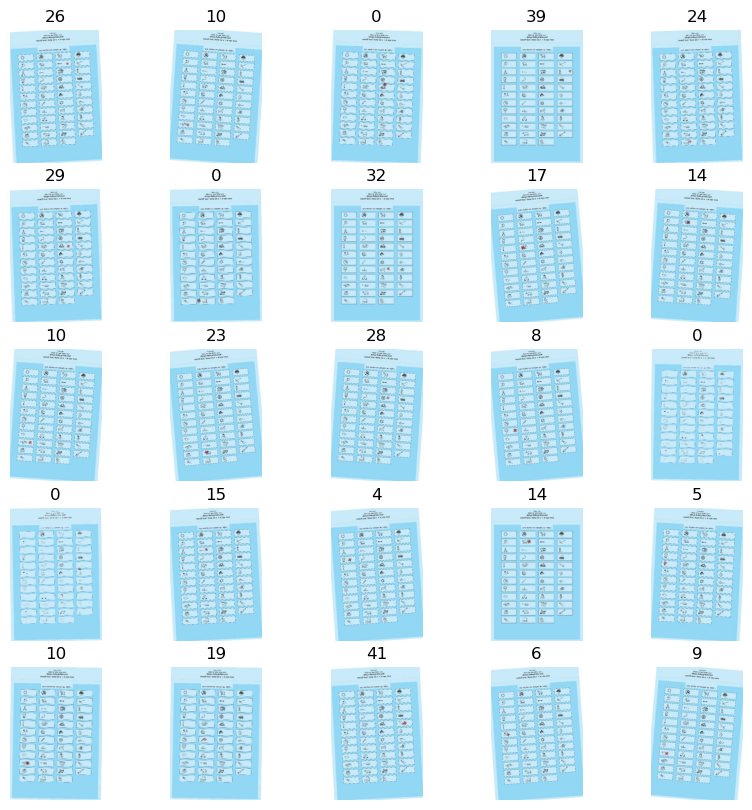

In [6]:
#visualizing some random data

rows, cols = 5, 5
plt.figure(figsize=(10,10))

for i in range(rows*cols):
    idx = torch.randint(0, len(data), size=[1]).item()
    plt.subplot(rows, cols, i+1)
    image = cv2.imread('train/' + data['data'][idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(data['label'][idx])
    plt.axis('off')

In [7]:
#creating transforms using albumentations

train_transforms = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
])

test_transforms = A.Compose([
    A.Resize(128, 128),
])

In [57]:
#creating dataset

class ImageData(Dataset):
    def __init__(self, data, transform=None):
        super().__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_path = 'train/' + data['data'][idx]
        label = data['label'][idx]

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # apply transforms if any
        if self.transform:
            image = self.transform(image=image)['image']
            image = np.transpose(image, (2, 0, 1)).astype(np.float32) # pytorch expects channel first (c, h, w)
            image = torch.tensor(image, dtype=torch.float)
            return image, label

        return image, label
        
        


In [58]:
train_dataloader = DataLoader(ImageData(data, train_transforms), batch_size=32, shuffle=True)
test_dataloader = DataLoader(ImageData(test_data, test_transforms), batch_size=32, shuffle=False)

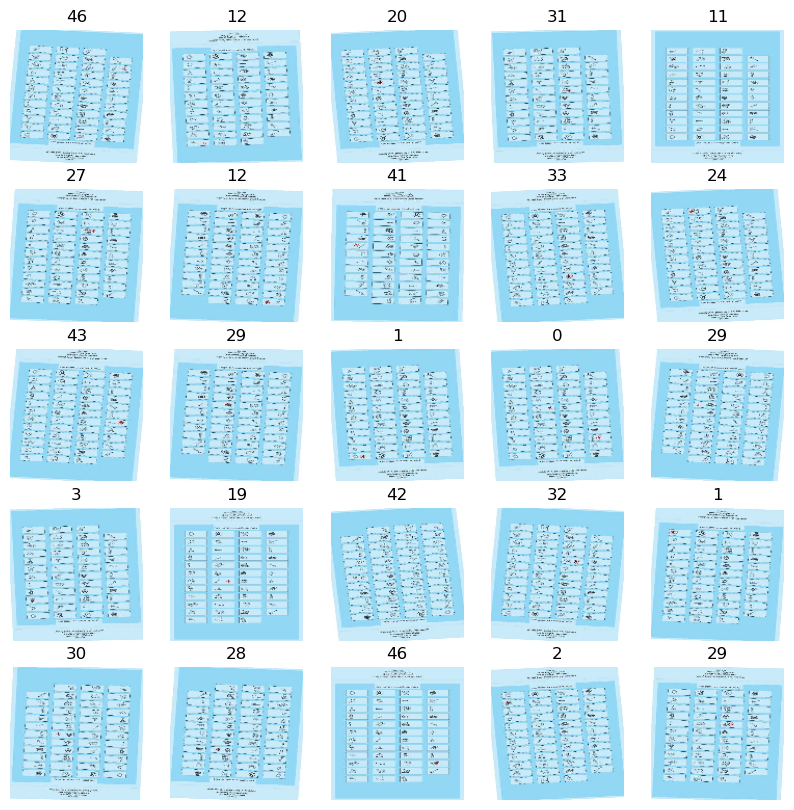

In [10]:
#visualizing some random data after applying transforms

rows, cols = 5, 5
plt.figure(figsize=(10,10))
check_data = next(iter(train_dataloader)) # get a batch of data that has two elements: image on index 0 and label on index 1

for i in range(rows*cols):
    plt.subplot(rows, cols, i+1)
    image = check_data[0][i].permute(1, 2, 0).numpy() #getting image from batch and converting channel first to channel last also converting to numpy array
    plt.imshow(image.astype(np.uint8))
    plt.title(check_data[1][i].item())
    plt.axis('off')

In [11]:
#creating model

class Model(nn.Module):
    def __init__(self, input_features: int, hidden_units: int, output_features: int):
        super().__init__()
        self.block_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=input_features, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.block_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units*2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.block_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units*2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2*hidden_units*16*16, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, output_features)
        )

    def forward(self, x):
        x = self.block_conv1(x)
        x = self.block_conv2(x)
        x = self.block_conv3(x)
        x = self.classifier(x)
        return x


In [12]:
model = Model(input_features=3, hidden_units=32, output_features=48).to(device)

In [13]:
dummy = torch.randn(1, 3, 128, 128).to(device)
model(dummy)

tensor([[-0.4964, -0.3577,  0.4570,  0.1206, -0.4224, -0.2723, -0.2389,  0.3839,
          0.2260,  0.2713, -0.4461,  0.0458, -0.3102,  0.1965, -0.4977,  0.4611,
         -0.0140,  0.7004,  0.1168,  0.0678, -0.1076,  0.2101, -0.6908,  0.3748,
          0.0750, -0.5337, -0.4998, -0.0849, -0.1065, -0.3437,  0.0768, -0.1920,
          0.7032, -0.1907,  0.2659,  0.5136,  0.3031,  0.1008,  0.0387,  0.7713,
          0.8048, -0.5859,  0.2094,  0.0839,  0.4064, -0.4464,  0.7521,  0.9807]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [14]:
# defining loss function and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# defining accuracy function
def accuracy_fn(y_pred, y_true):
    y_pred = torch.argmax(y_pred, dim=1)
    return torch.sum(y_pred == y_true).item() / len(y_true)

In [15]:
#defining train and test step

def train_step(model: nn.Module,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               data_loader: DataLoader,
               device: torch.device = device):
    
    model.train()
    train_loss, train_acc = 0.0, 0.0

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss

        acc = accuracy_fn(y_pred, y)
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"Batch: {batch}, Train Loss: {loss.item():.4f}, Train Acc: {acc:.4f}")
            print(f"looke at {batch * len(X)}/{len(data_loader.dataset)} samples")

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")


def test_step(model: nn.Module,
              loss_fn: nn.Module,
              accuracy_fn,
              data_loader: DataLoader,
              device: torch.device = device):
    
    model.eval()
    test_loss, test_acc = 0.0, 0.0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(data_loader):
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss

            acc = accuracy_fn(y_pred, y)
            test_acc += acc

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

In [16]:
# #training model with first batch(checking if model is working or not)

# epochs = 60
# first_train_batch = next(iter(train_dataloader))
# first_test_batch = next(iter(test_dataloader))
# X, y = first_train_batch[0], first_train_batch[1]
# X_test, y_test = first_test_batch[0], first_test_batch[1]

# for epoch in tqdm(range(epochs)):
#     X, y = X.to(device), y.to(device)
#     y_pred = model(X)
#     loss = loss_fn(y_pred, y)
#     acc = accuracy_fn(y_pred, y)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     model.eval()
#     with torch.inference_mode():
#         X_test, y_test = X_test.to(device), y_test.to(device)
#         y_pred_test = model(X_test)
#         loss_test = loss_fn(y_pred_test, y_test)
#         acc_test = accuracy_fn(y_pred_test, y_test)
#     print(f"Epoch {epoch+1} of {epochs}")
#     print(f"Train Loss: {loss.item():.4f} | Train Acc: {acc:.4f} | Test loss:{loss_test.item():.4f} | Test acc:{acc_test:.4f}\n")


In [17]:
#training model

epochs = 10

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1} of {epochs}")
    train_step(model=model,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               data_loader=train_dataloader,
               device=device)
    
    test_step(model=model,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              data_loader=test_dataloader,
              device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 of 10
Batch: 0, Train Loss: 4.1114, Train Acc: 0.0000
looke at 0/91960 samples
Batch: 400, Train Loss: 3.9164, Train Acc: 0.0000
looke at 12800/91960 samples
Batch: 800, Train Loss: 3.9071, Train Acc: 0.0000
looke at 25600/91960 samples
Batch: 1200, Train Loss: 3.9381, Train Acc: 0.0312
looke at 38400/91960 samples
Batch: 1600, Train Loss: 3.7126, Train Acc: 0.0625
looke at 51200/91960 samples
Batch: 2000, Train Loss: 3.7876, Train Acc: 0.0938
looke at 64000/91960 samples
Batch: 2400, Train Loss: 3.6864, Train Acc: 0.1250
looke at 76800/91960 samples
Batch: 2800, Train Loss: 2.2846, Train Acc: 0.4062
looke at 89600/91960 samples
Train Loss: 3.6978, Train Acc: 0.0775


 10%|█         | 1/10 [31:18<4:41:48, 1878.68s/it]

Test Loss: 2.0168, Test Acc: 0.5999
Epoch 2 of 10
Batch: 0, Train Loss: 2.0516, Train Acc: 0.4062
looke at 0/91960 samples
Batch: 400, Train Loss: 1.1854, Train Acc: 0.8438
looke at 12800/91960 samples
Batch: 800, Train Loss: 0.7107, Train Acc: 0.8750
looke at 25600/91960 samples
Batch: 1200, Train Loss: 0.7973, Train Acc: 0.8438
looke at 38400/91960 samples
Batch: 1600, Train Loss: 0.5466, Train Acc: 0.9375
looke at 51200/91960 samples
Batch: 2000, Train Loss: 0.3354, Train Acc: 0.9688
looke at 64000/91960 samples
Batch: 2400, Train Loss: 0.2956, Train Acc: 0.9688
looke at 76800/91960 samples
Batch: 2800, Train Loss: 0.4185, Train Acc: 0.9688
looke at 89600/91960 samples
Train Loss: 0.7313, Train Acc: 0.8548


 20%|██        | 2/10 [56:39<3:42:23, 1667.95s/it]

Test Loss: 0.1664, Test Acc: 0.9842
Epoch 3 of 10
Batch: 0, Train Loss: 0.2503, Train Acc: 0.9688
looke at 0/91960 samples
Batch: 400, Train Loss: 0.1477, Train Acc: 1.0000
looke at 12800/91960 samples
Batch: 800, Train Loss: 0.1831, Train Acc: 0.9688
looke at 25600/91960 samples
Batch: 1200, Train Loss: 0.1723, Train Acc: 1.0000
looke at 38400/91960 samples
Batch: 1600, Train Loss: 0.1155, Train Acc: 1.0000
looke at 51200/91960 samples
Batch: 2000, Train Loss: 0.3590, Train Acc: 0.9375
looke at 64000/91960 samples
Batch: 2400, Train Loss: 0.1216, Train Acc: 0.9688
looke at 76800/91960 samples
Batch: 2800, Train Loss: 0.0782, Train Acc: 0.9688
looke at 89600/91960 samples
Train Loss: 0.1736, Train Acc: 0.9777


 30%|███       | 3/10 [1:09:53<2:28:03, 1269.01s/it]

Test Loss: 0.0829, Test Acc: 0.9885
Epoch 4 of 10
Batch: 0, Train Loss: 0.0790, Train Acc: 1.0000
looke at 0/91960 samples
Batch: 400, Train Loss: 0.0417, Train Acc: 1.0000
looke at 12800/91960 samples
Batch: 800, Train Loss: 0.0460, Train Acc: 1.0000
looke at 25600/91960 samples
Batch: 1200, Train Loss: 0.1049, Train Acc: 0.9688
looke at 38400/91960 samples
Batch: 1600, Train Loss: 0.0399, Train Acc: 1.0000
looke at 51200/91960 samples
Batch: 2000, Train Loss: 0.1700, Train Acc: 0.9375
looke at 64000/91960 samples
Batch: 2400, Train Loss: 0.4082, Train Acc: 0.9375
looke at 76800/91960 samples
Batch: 2800, Train Loss: 0.1176, Train Acc: 0.9375
looke at 89600/91960 samples
Train Loss: 0.1093, Train Acc: 0.9826


 40%|████      | 4/10 [1:23:51<1:49:53, 1098.91s/it]

Test Loss: 0.0575, Test Acc: 0.9891
Epoch 5 of 10
Batch: 0, Train Loss: 0.1035, Train Acc: 0.9688
looke at 0/91960 samples
Batch: 400, Train Loss: 0.1290, Train Acc: 0.9375
looke at 12800/91960 samples
Batch: 800, Train Loss: 0.0325, Train Acc: 1.0000
looke at 25600/91960 samples
Batch: 1200, Train Loss: 0.0465, Train Acc: 1.0000
looke at 38400/91960 samples
Batch: 1600, Train Loss: 0.0667, Train Acc: 0.9688
looke at 51200/91960 samples
Batch: 2000, Train Loss: 0.0337, Train Acc: 1.0000
looke at 64000/91960 samples
Batch: 2400, Train Loss: 0.0500, Train Acc: 1.0000
looke at 76800/91960 samples
Batch: 2800, Train Loss: 0.0441, Train Acc: 1.0000
looke at 89600/91960 samples
Train Loss: 0.0843, Train Acc: 0.9849


 50%|█████     | 5/10 [1:38:04<1:24:10, 1010.08s/it]

Test Loss: 0.0478, Test Acc: 0.9928
Epoch 6 of 10
Batch: 0, Train Loss: 0.0269, Train Acc: 1.0000
looke at 0/91960 samples
Batch: 400, Train Loss: 0.0238, Train Acc: 1.0000
looke at 12800/91960 samples
Batch: 800, Train Loss: 0.2078, Train Acc: 0.9688
looke at 25600/91960 samples
Batch: 1200, Train Loss: 0.0527, Train Acc: 1.0000
looke at 38400/91960 samples
Batch: 1600, Train Loss: 0.0469, Train Acc: 1.0000
looke at 51200/91960 samples
Batch: 2000, Train Loss: 0.0468, Train Acc: 1.0000
looke at 64000/91960 samples
Batch: 2400, Train Loss: 0.0423, Train Acc: 1.0000
looke at 76800/91960 samples
Batch: 2800, Train Loss: 0.0126, Train Acc: 1.0000
looke at 89600/91960 samples
Train Loss: 0.0680, Train Acc: 0.9868


 60%|██████    | 6/10 [1:51:36<1:02:50, 942.70s/it] 

Test Loss: 0.0390, Test Acc: 0.9918
Epoch 7 of 10
Batch: 0, Train Loss: 0.0476, Train Acc: 1.0000
looke at 0/91960 samples
Batch: 400, Train Loss: 0.0231, Train Acc: 1.0000
looke at 12800/91960 samples
Batch: 800, Train Loss: 0.0373, Train Acc: 1.0000
looke at 25600/91960 samples
Batch: 1200, Train Loss: 0.0180, Train Acc: 1.0000
looke at 38400/91960 samples
Batch: 1600, Train Loss: 0.0361, Train Acc: 1.0000
looke at 51200/91960 samples
Batch: 2000, Train Loss: 0.0261, Train Acc: 1.0000
looke at 64000/91960 samples
Batch: 2400, Train Loss: 0.0225, Train Acc: 1.0000
looke at 76800/91960 samples
Batch: 2800, Train Loss: 0.1336, Train Acc: 0.9688
looke at 89600/91960 samples
Train Loss: 0.0568, Train Acc: 0.9885


 70%|███████   | 7/10 [2:04:59<44:51, 897.27s/it]  

Test Loss: 0.0311, Test Acc: 0.9936
Epoch 8 of 10
Batch: 0, Train Loss: 0.0620, Train Acc: 0.9688
looke at 0/91960 samples
Batch: 400, Train Loss: 0.0965, Train Acc: 0.9688
looke at 12800/91960 samples
Batch: 800, Train Loss: 0.0152, Train Acc: 1.0000
looke at 25600/91960 samples
Batch: 1200, Train Loss: 0.0203, Train Acc: 1.0000
looke at 38400/91960 samples
Batch: 1600, Train Loss: 0.0623, Train Acc: 0.9688
looke at 51200/91960 samples
Batch: 2000, Train Loss: 0.0512, Train Acc: 0.9688
looke at 64000/91960 samples
Batch: 2400, Train Loss: 0.0168, Train Acc: 1.0000
looke at 76800/91960 samples
Batch: 2800, Train Loss: 0.0073, Train Acc: 1.0000
looke at 89600/91960 samples
Train Loss: 0.0466, Train Acc: 0.9906


 80%|████████  | 8/10 [2:18:10<28:46, 863.49s/it]

Test Loss: 0.0231, Test Acc: 0.9953
Epoch 9 of 10
Batch: 0, Train Loss: 0.0120, Train Acc: 1.0000
looke at 0/91960 samples
Batch: 400, Train Loss: 0.0185, Train Acc: 1.0000
looke at 12800/91960 samples
Batch: 800, Train Loss: 0.0076, Train Acc: 1.0000
looke at 25600/91960 samples
Batch: 1200, Train Loss: 0.0716, Train Acc: 0.9688
looke at 38400/91960 samples
Batch: 1600, Train Loss: 0.0129, Train Acc: 1.0000
looke at 51200/91960 samples
Batch: 2000, Train Loss: 0.0183, Train Acc: 1.0000
looke at 64000/91960 samples
Batch: 2400, Train Loss: 0.0186, Train Acc: 1.0000
looke at 76800/91960 samples
Batch: 2800, Train Loss: 0.0237, Train Acc: 1.0000
looke at 89600/91960 samples
Train Loss: 0.0402, Train Acc: 0.9917


 90%|█████████ | 9/10 [2:31:24<14:01, 841.50s/it]

Test Loss: 0.0197, Test Acc: 0.9961
Epoch 10 of 10
Batch: 0, Train Loss: 0.0065, Train Acc: 1.0000
looke at 0/91960 samples
Batch: 400, Train Loss: 0.0217, Train Acc: 1.0000
looke at 12800/91960 samples
Batch: 800, Train Loss: 0.0066, Train Acc: 1.0000
looke at 25600/91960 samples
Batch: 1200, Train Loss: 0.0133, Train Acc: 1.0000
looke at 38400/91960 samples
Batch: 1600, Train Loss: 0.0178, Train Acc: 1.0000
looke at 51200/91960 samples
Batch: 2000, Train Loss: 0.0069, Train Acc: 1.0000
looke at 64000/91960 samples
Batch: 2400, Train Loss: 0.0367, Train Acc: 0.9688
looke at 76800/91960 samples
Batch: 2800, Train Loss: 0.0354, Train Acc: 1.0000
looke at 89600/91960 samples
Train Loss: 0.0358, Train Acc: 0.9930


100%|██████████| 10/10 [2:45:10<00:00, 991.05s/it]

Test Loss: 0.0181, Test Acc: 0.9963


Test Loss: 0.0072, Test Acc: 1.0000


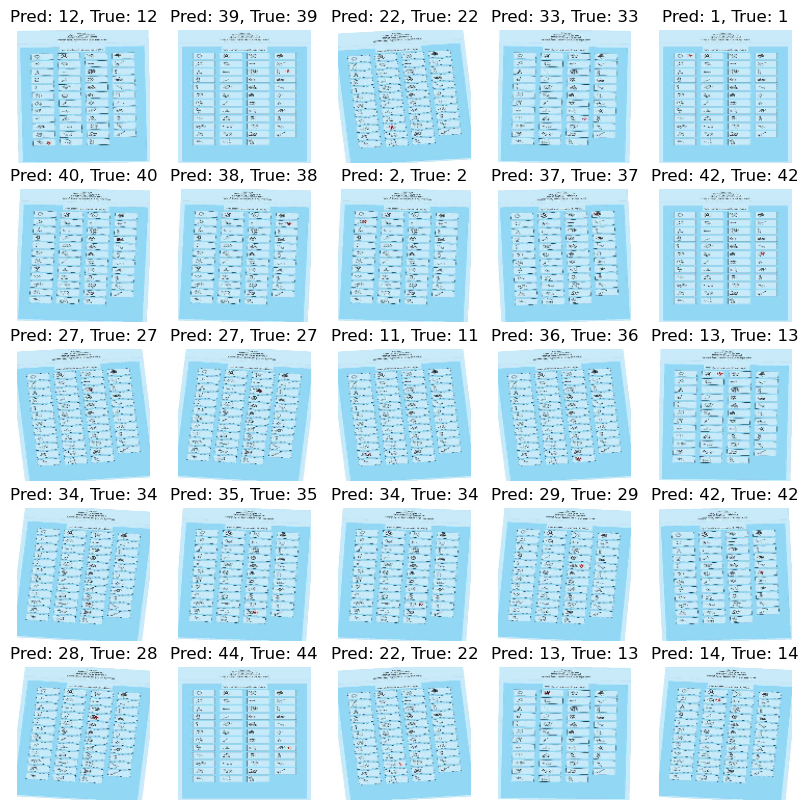

In [20]:
#model evaluation on single batch

test_batch = next(iter(test_dataloader))
X_test, y_test = test_batch[0], test_batch[1]

model.eval()
with torch.inference_mode():
    X_test, y_test = X_test.to(device), y_test.to(device)
    y_pred_test = model(X_test)
    loss_test = loss_fn(y_pred_test, y_test)
    acc_test = accuracy_fn(y_pred_test, y_test)
    print(f"Test Loss: {loss_test.item():.4f}, Test Acc: {acc_test:.4f}")

#visualizing model predictions on single batch
rows, cols = 5, 5
plt.figure(figsize=(10, 10))

for i in range(rows*cols):
    image = X_test[i].permute(1, 2, 0).cpu().numpy()
    image = image.astype(np.uint8)
    plt.subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(image)
    plt.title(f"Pred: {torch.argmax(y_pred_test[i])}, True: {y_test[i]}")

In [21]:
#saving the model
torch.save(model.state_dict(), "model.pth")